In [ ]:
# Date: 20.3.2023
# Author: Antti Kiviaho
#
# Notebook for analysing and visualizing visium data after copy number variation, single cell mapping and clustering
# analyses. This is the main results notebook

## Packages and data download

In [2]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

#from cell2location.utils import select_slide
#from cell2location.plt import plot_spatial

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids
import matplotlib as mpl

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Download data and format cell2location mapping results into obs columns in both aggregated adata and individual slides
#c2l-results/cell2location_map_20230322/
adata_vis = sc.read_h5ad('./c2l-results/visium_adata_with_c2l_mapping_20230621.h5ad')

adata_vis.obs.joint_leiden_clusters = adata_vis.obs.sample_id.astype(str) + '_' + adata_vis.obs.joint_leiden_clusters.astype(str)
adata_vis.obs['joint_leiden_clusters'] = pd.Categorical(adata_vis.obs['joint_leiden_clusters'])


adata_slides = load_from_pickle('./data/individual_sections_normalized_clustered.pickle')
samples = get_sample_ids()

# Copy obsm (cell2location results) to adata object obs
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# Copy obsm (cell2location results) to individual slides
for sample in samples:
    vis_subset = adata_vis[adata_vis.obs['sample_id']==sample]
    
    if (vis_subset.obs_names == adata_slides[sample].obs_names).all():
        adata_slides[sample].obsm = vis_subset.obsm.copy()
        
        # add 5% quantile, representing confident cell abundance, 'at least this amount is present',
        # to adata.obs with nice names for plotting
        adata_slides[sample].uns['mod'] = vis_subset.uns['mod'].copy()
        adata_slides[sample].obs[adata_slides[sample].uns['mod']['factor_names']] = adata_slides[sample].obsm['q05_cell_abundance_w_sf']


## Nuclei counting breakdown

In [3]:
# Looking at segmentation-based nuclei counts
nuclei_counts = load_from_pickle('visium_slide_nuclei_counts.pickle')
nuclei_counts['n_nuclei'] = nuclei_counts['n_nuclei'].astype(int)

meta = adata_vis.obs.copy()
meta = pd.merge(meta,nuclei_counts,left_index=True,right_index=True,how='left')
if (meta.index == adata_vis.obs.index).all():
    adata_vis.obs = meta
    print('merged!')

merged!


## Visium mapping plots

In [ ]:
# Plots and saves top n_types with highest prevelance on visium slides
n_types = 12

for sample in samples:
    slide = adata_slides[sample]
    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types]

    # plot in spatial coordinates
    with mpl.rc_context({'axes.facecolor':  'black',
                        'figure.figsize': [4.5, 5]}):

        sc.pl.spatial(slide, cmap='magma',
                    # show first 8 cell types
                    color=cell_types.index,
                    ncols=4, size=1.3,alpha_img=0.8,
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax='p99.2', show=False
                    )
        plt.savefig('./plots/c2l_mapping_results_20230621/'+sample+'_c2l_mapping_top12_abundant.png',dpi=200)
        plt.clf()

In [ ]:
## Side by side violin plots of abundant cell types + spatial 

plt.rcParams.update({'axes.titlesize': 'small'})

n_types = 6
obs_name = 'joint_leiden_clusters'

for s in samples:

    slide = adata_slides[s]

    # Subset to only plot the cell types with highest mean prevalence
    cell_types = slide.obs.iloc[:,16:].mean(axis=0).sort_values(ascending=False)[:n_types].index

    fig = plt.figure(figsize=(12,12))

    gs = fig.add_gridspec(6,3)
    ax6 = fig.add_subplot(gs[:, 1:3])

    # Plot the data in the left column subplots
    for i in range(6):

        ax_plotting = fig.add_subplot(gs[i,0])

        sc.pl.violin(slide,groupby=obs_name,keys=cell_types[i],jitter=False,rotation=45,inner='box',
                    ax=ax_plotting,show=False)
        
        ax_plotting.yaxis.label.set_size(12)
        #ax_plotting.yaxis.label.set_rotation('horizontal')

        if i < 5:  # only remove x-labels for the top 5 subplots on the left
            ax_plotting.tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

    sc.pl.spatial(adata_slides[s],color='joint_leiden_clusters',size=1.3,ax=ax6)

    fig.savefig('./plots/c2l_mapping_results_20230621/'+s+'_cell_type_prevalences_per_cluster.png')
    fig.clf()



In [ ]:
cell_types = ['luminal-like epithelium', 'ERG tumor epithelium', 'inflammatory fibroblasts','myofibroblasts']
cell_types2 = ['basal-like epithelium', 'prostaglandind active epithelium','antigen presenting fibroblasts','pericytes']

for sample in samples:
    slide = adata_slides[sample]
    fig, axs = plt.subplots(2, 4, sharey='row')
    for i, cell_type in enumerate(cell_types):
        axs[0, i].set_ylim([0, 20])
        sc.pl.violin(slide, groupby='joint_leiden_clusters', keys=cell_type, jitter=False,
            rotation=45, inner='box', show=False, ax=axs[0, i])
    for i, cell_type in enumerate(cell_types2):
        axs[1, i].set_ylim([0, 10])
        sc.pl.violin(slide, groupby='joint_leiden_clusters', keys=cell_type, jitter=False,
            rotation=45, inner='box', show=False, ax=axs[1, i])
    plt.gcf().set_size_inches(16, 8)
    plt.savefig(os.path.join('plots/c2l_mapping_results_20230621', f'{sample}_8_celltypes_violinplots.pdf'))
    plt.clf()


## Secondary analysis of the cell type mapping numbers

In [134]:
# Creating an anndata-structure for inferred cell numbers

# Filters if necessary
ctypes = adata_vis.uns['mod']['factor_names']
#ctypes = [ctype for ctype in ctypes if 'epithelial' in ctype or 'fibroblast' in ctype]

cell_mapping_dat = sc.AnnData(adata_vis.obs[ctypes])
if (cell_mapping_dat.obs.index == adata_vis.obs.index).all():
    cell_mapping_dat.obs = adata_vis.obs[['sample_id','joint_leiden_clusters']]


if (adata_vis.obs.index == cell_mapping_dat.obs.index).all():
    adata_vis.obs['inferred_cell_counts'] = np.round(np.sum(cell_mapping_dat.X,axis=1),0).tolist()
    print('Inferred cell counts copied!')


# extract first string before '-' or '_'
cell_mapping_dat.obs['phenotype'] = cell_mapping_dat.obs['sample_id'].str.extract('([^\-_]+)', expand=False)

cell_mapping_dat.layers['counts'] = cell_mapping_dat.X.copy()
sc.pp.normalize_total(cell_mapping_dat)


Inferred cell counts copied!


In [135]:
sc.pp.pca(cell_mapping_dat)
sc.pp.neighbors(cell_mapping_dat)
sc.tl.umap(cell_mapping_dat)
sc.tl.leiden(cell_mapping_dat,key_added='mapping_based_clusters', resolution=0.3)

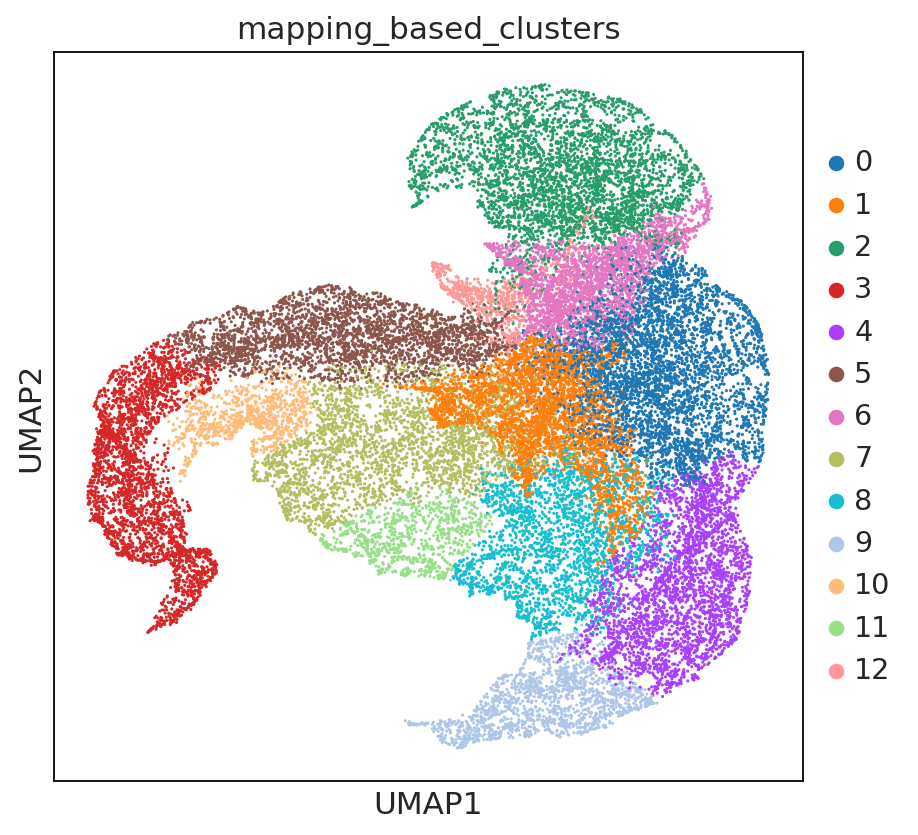

In [136]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(cell_mapping_dat,color='mapping_based_clusters',s=8)

In [ ]:
# Save the data (just plots below)
cell_mapping_dat.write('c2l_mapping_in_anndata_20230621.h5ad')

In [126]:
import matplotlib.pyplot as plt

sc.set_figure_params(scanpy=True, fontsize=8,frameon=True)

for mapping_cl in list(cell_mapping_dat.obs['mapping_based_clusters'].cat.categories):
    slide = cell_mapping_dat[cell_mapping_dat.obs['mapping_based_clusters'] == mapping_cl]

    # Extract the top 5 most prevalent cell types in this cluster
    cell_types = list(slide.var_names[np.argsort(slide.X.mean(axis=0))[::-1][:5]])

    fig, axs = plt.subplots(1, 5, sharey='row', figsize=(8,4))
    fig.suptitle('Top 5 most prevalent cell types for cluster ' + mapping_cl, fontsize=14)
    for i, cell_type in enumerate(cell_types):

        plot_dat = slide.copy()
        plot_dat.obs['mapping_based_clusters'] = plot_dat.obs['mapping_based_clusters'].replace({mapping_cl:cell_type})

        axs[i].set_ylim([0, int(np.max(plot_dat.X))])

        sc.pl.violin(plot_dat,
                    groupby='mapping_based_clusters', keys=cell_type, jitter=False, inner='box', show=False, ax=axs[i],
                    title=mapping_cl,xlabel='',ylabel='',rotation=15,palette='Greys')

    plt.savefig(os.path.join('plots/c2l_mapping_results_20230621/mapping_based_clusters/', f'{mapping_cl}_cluster_celltypes_violinplots.pdf'))
    plt.clf()


<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

<Figure size 640x320 with 0 Axes>

In [106]:
def generate_colors(n_colors=17):
    import colorsys

    #define number of colors to generate
    num_colors = 37

    #initialize hue, saturation and value
    hue = 0
    saturation = 0.5
    value = 0.95

    #empty list to store colors
    colors = []

    #generate colors
    for i in range(num_colors):
        hue = (hue + 0.618033988749895) % 1.0 
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        color = (r, g, b)
        colors.append(color)

    #convert to Seaborn color palette
    sns_palette = sns.color_palette(colors)

    return(sns_palette)


def plot_stacked_bar(data,sum_variable='phenotype',plot_variable='VI_clusters',filter_kw='',plot_legend=False):

    cud_palette = generate_colors(len(np.unique(data.obs[sum_variable])))
    sns.set_palette(cud_palette)

    
    plot_data = data.obs[[sum_variable,plot_variable]]

    plot_data = plot_data.groupby(sum_variable)[plot_variable].value_counts()
    plot_data = plot_data.unstack(sum_variable)
    plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)

    # Order according to decreasing number of sample represented
    plot_data = plot_data.sort_index(ascending=False)
    
    if plot_legend == True:
        plot_data.plot.barh(stacked=True,figsize=(10,10),grid=False).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    else:
        plot_data.plot.barh(stacked=True,figsize=(10,10),grid=False,legend=False,sort_columns=False)
    return plot_data


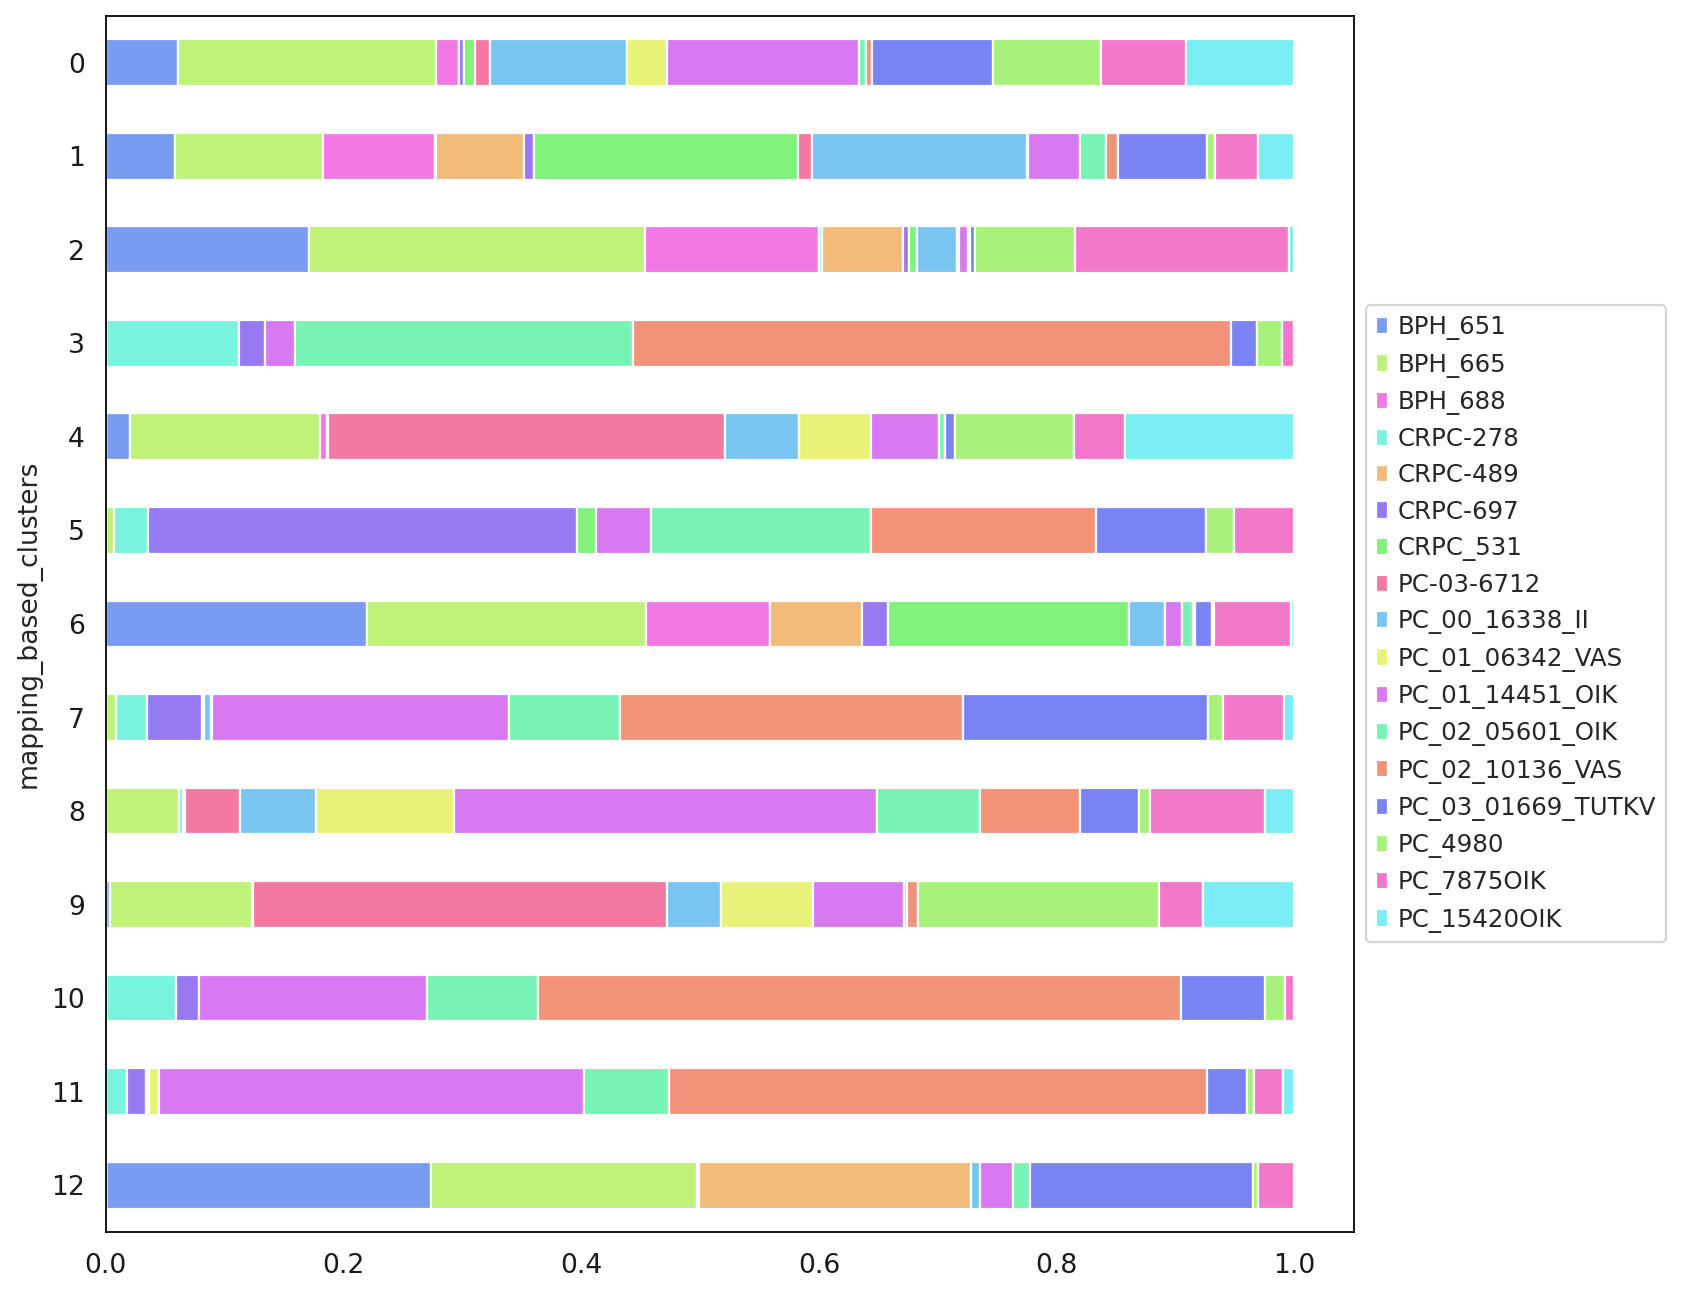

In [128]:
sc.set_figure_params(scanpy=True, fontsize=12,frameon=True)
plot_dat = plot_stacked_bar(cell_mapping_dat,sum_variable='sample_id',plot_variable='mapping_based_clusters',plot_legend=True)

In [65]:
for s in samples:
    vis_subset = cell_mapping_dat[cell_mapping_dat.obs['sample_id']==s]
    if (vis_subset.obs_names == adata_slides[s].obs_names).all():
        adata_slides[s].obs['mapping_based_clusters'] = vis_subset.obs['mapping_based_clusters'].copy()

    # calculating neighborhood enrichments on a per sample basis
    sq.gr.spatial_neighbors(adata_slides[s])
    sq.gr.nhood_enrichment(adata_slides[s], cluster_key="mapping_based_clusters",show_progress_bar=False)


In [137]:
#sq.pl.nhood_enrichment(adata_slides[samples[0]],cluster_key='mapping_based_clusters')

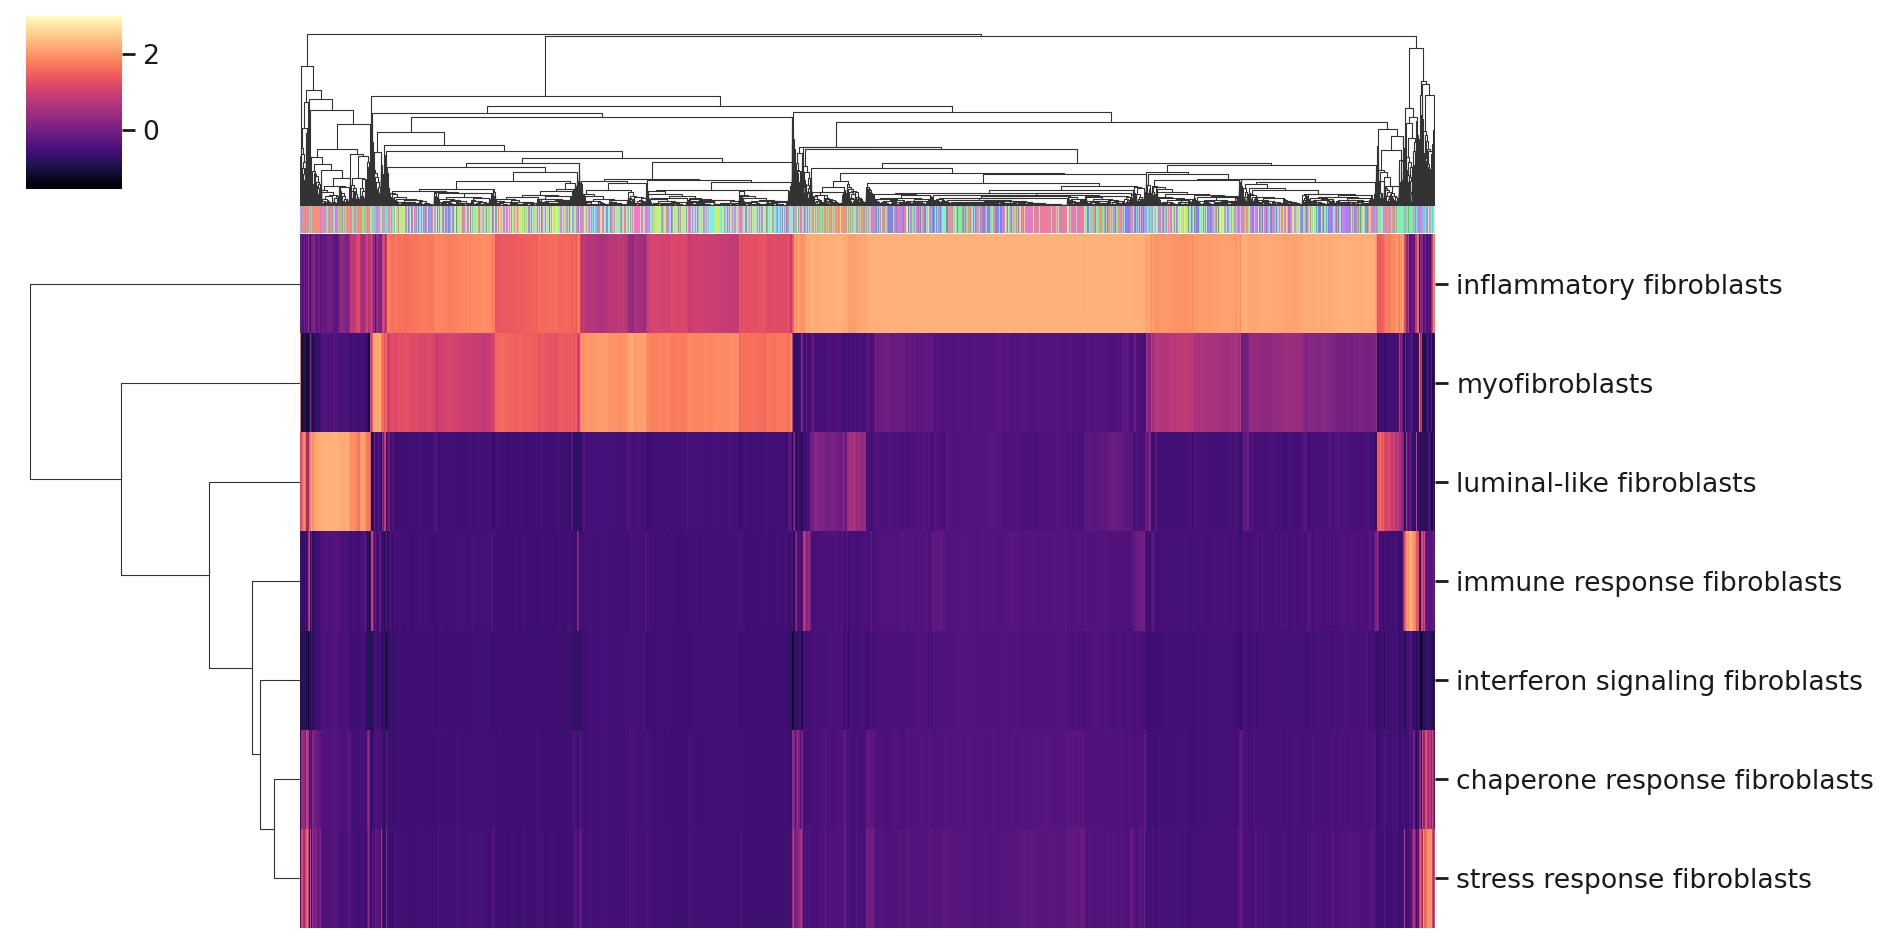

In [131]:
# Plotting the cluster-averaged cell counts into a heatmap for easier interpretation
ctype_start = 0
n_ctypes = 15
n_cells_col_cap = 3

# Take 10 most prevalent cell types and use them for the heatmap
#heatmap_vars = np.array(cell_mapping_dat.var_names[np.argsort(np.sum(
#    cell_mapping_dat.X,axis=0))[::-1]])[ctype_start:ctype_start + n_ctypes]

# Backup for taking specific cell types
heatmap_vars = [x for x in cell_mapping_dat.var_names if "fibro" in x] # Fibroblasts etc.


# Convert X and annotations to pandas DataFrame
df = pd.DataFrame(cell_mapping_dat.X)
df.columns = cell_mapping_dat.var_names
df = df[heatmap_vars]

# Extract sample names from index values
sample_names = adata_vis.obs['sample_id']

# Create a dictionary that maps each sample name to a color
color_map = {sample: sns.color_palette()[i] for i, sample in enumerate(sorted(set(sample_names)))}

# Use the color_map dictionary to assign colors to each index value
colors = [color_map[sample_name] for sample_name in sample_names]

sns.clustermap(df.T, col_colors=colors, cmap='magma', z_score=1,
                vmax=n_cells_col_cap, figsize=(12,6), xticklabels=False)


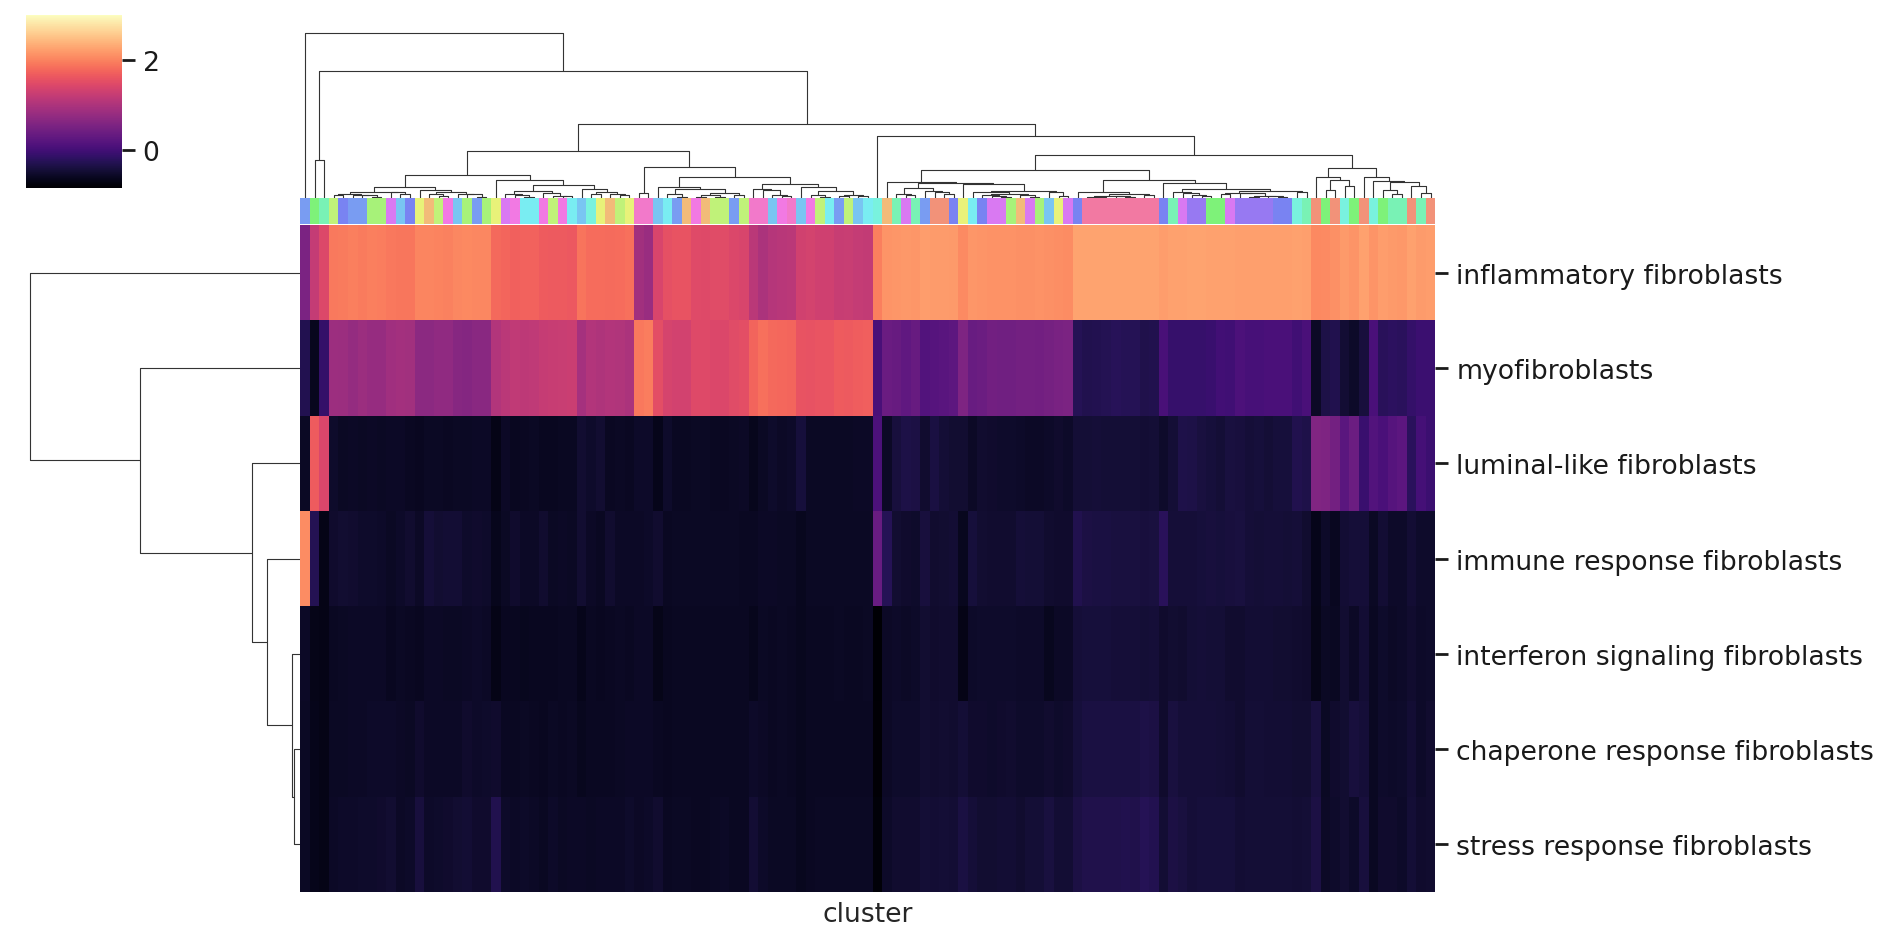

In [132]:
# Plotting the cluster-averaged cell counts into a heatmap for easier interpretation
ctype_start = 0
n_ctypes = 15
n_cells_col_cap = 3

# Take 10 most prevalent cell types and use them for the heatmap
#heatmap_vars = np.array(cell_mapping_dat.var_names[np.argsort(np.sum(
#    cell_mapping_dat.X,axis=0))[::-1]])[ctype_start:ctype_start + n_ctypes]

# Backup for taking specific cell types
heatmap_vars = [x for x in cell_mapping_dat.var_names if "fibro" in x]


# Convert X and annotations to pandas DataFrame
df = pd.DataFrame(cell_mapping_dat.X)
df['cluster'] = cell_mapping_dat.obs['joint_leiden_clusters'].tolist()
#df['sample_id'] = cell_mapping_dat.obs['sample_id']

# Group rows by their annotation values and calculate the average of each group
averaged_df = df.groupby('cluster').mean()
averaged_df.columns = cell_mapping_dat.var_names

averaged_df = averaged_df[heatmap_vars]

# Extract sample names from index values
sample_names = ['_'.join(index.split("_")[:-1]) for index in averaged_df.index]

# Create a dictionary that maps each sample name to a color
color_map = {sample: sns.color_palette()[i] for i, sample in enumerate(sorted(set(sample_names)))}

# Use the color_map dictionary to assign colors to each index value
colors = [color_map[sample_name] for sample_name in sample_names]

sns.clustermap(averaged_df.T, col_colors=colors, cmap='magma', z_score=1,
                vmax=n_cells_col_cap, figsize=(12,6), xticklabels=False)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create an empty plot
fig, ax = plt.subplots()

# Create a list of labels and colors
legend_labels = list(color_map.keys())
legend_colors = list(color_map.values())

# Convert the float tuples to valid RGB color strings
colors = ['#%02x%02x%02x' % tuple(int(255*x) for x in color) for color in legend_colors]

# Create color patches for each label
patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

# Add the legend to the plot
ax.legend(handles=patches, prop={"size": 10}, loc='best', framealpha=1, edgecolor='black', facecolor='white',
          title='Legend Title', labelcolor='black', fancybox=True, shadow=True,  bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()


## Spatial Leiden cluster merging 

In [ ]:
from sklearn.metrics import silhouette_score, pairwise_distances

# Define functions

## Calclulates the euclidean distance on cluster level yield to information about which clusters are closest to each other
def calculate_distances(cluster_means_df,n_closest=5):
    closest_names = np.empty((0,n_closest))
    closest_dist = np.empty((0,n_closest))

    for idx in range (len(cluster_means_df)):

        # Divide the df into the query (1 cluster) and the rest
        comparison_dat = cluster_means_df.iloc[idx]
        rest_of_the_dat = cluster_means_df.drop(index=[cluster_means_df.index[idx]])

        # Repeat one row to match the shape of the rest
        comparison_dat_reshaped = np.tile(comparison_dat,(rest_of_the_dat.shape[0],1))
        res = np.linalg.norm(rest_of_the_dat-comparison_dat_reshaped,axis=1)
        matches = np.asarray(list(rest_of_the_dat.index[np.argsort(res)[:n_closest]]))

        # Stack names and distances of closest matches
        closest_names = np.vstack([closest_names,matches])
        closest_dist = np.vstack([closest_dist,np.sort(res)[:n_closest]])

    # Convert to dataframes for easy slicing
    closest_names = pd.DataFrame(closest_names,index=cluster_means_df.index)
    closest_dist = pd.DataFrame(closest_dist,index=cluster_means_df.index)
    return(closest_names,closest_dist)

# Compare sample names of the index and the first column to find if the nearest cluster is from another sample. Only keep those
def find_nearest_neighbors(df):
    slices = []
    for idx in range(len(df)):
        if (('_').join(df.index[idx].split('_')[:-1]) != 
        ('_').join(df[0][idx].split('_')[:-1])):
            slices.append(idx)

    # These are the spatial clusters with different sample nearest cluster
    return(df.iloc[slices])

# Keep clusters that are mutual nearest neighbors (MNN)
def find_mnn_clusters(df):
    slices = []
    for idx in range(len(df)):
        if (df[0][idx] in df.index):
            if df.loc[df[0][idx]][0] == df.index[idx]:
                if df[0][idx] not in df.iloc[slices].index:
                    slices.append(idx)

    # These are the spatial clusters with mutual nearest neighbors
    return(df.iloc[slices])

def sample_is_duplicated(to_check,lst):
    found = False
    for element in lst:
        if to_check[:-2] in element:
            found = True
            break

    return found


    

In [ ]:
data_to_use = cell_mapping_dat

# Extracts spot level mapping values and averages to cluster level for mutual nearest neighbor comparison
spot_lvl_data = pd.DataFrame(data_to_use.X,index=data_to_use.obs_names)
spot_lvl_data['spatial_cluster'] = data_to_use.obs['joint_leiden_clusters'].copy()
spot_lvl_labs = data_to_use.obs['joint_leiden_clusters'].copy()

# Speed up the analysis by precomputing a distance matrix
#distance_array = pairwise_distances(cell_mapping_dat.X)
#ref_score = silhouette_score(distance_array,spot_lvl_labs,metric='precomputed')
ref_score = -1 # If the reference score is set to -1, we effectively lose the silhouette score if-clause

# A mapping-based clustering silhouette score is -0.23051132


In [ ]:
def is_score_ok(new_labs,df=distance_array, reference = ref_score):
    '''
    Checks the silhouette score of new clustering labels and compares them to a reference of 
    the original clustering
    '''
    new_score = silhouette_score(df,new_labs,metric='precomputed')
    if new_score > reference:
        return(True)
    else:
        return(False)

In [ ]:
# Take the cluster back to the original, unmerged leiden clusters
spot_lvl_data['merged_clusters'] = spot_lvl_data['spatial_cluster']
cluster_idx = 1
modified_clusters = dict()
len(spot_lvl_data['merged_clusters'].unique())

In [ ]:
## Iterate below code ###

In [ ]:
spot_lvl_labs = spot_lvl_data['merged_clusters'].copy()

# Calculate cluster means in the cell mapping space
cluster_lvl_dat = spot_lvl_data.groupby('merged_clusters').mean()

# Calculate euclidean distance between the clusters
names, dist = calculate_distances(cluster_lvl_dat)

# Find MNN clusters that are from different samples
filtered_names = find_nearest_neighbors(names)
cluster_pairs = find_mnn_clusters(filtered_names)
cluster_pairs

In [ ]:
# Find mergeable clusters by checking different conditions
# Iterate over the clusters
for idx in range(len(cluster_pairs)):
    inst_1 = str(cluster_pairs.index[idx])
    inst_2 = str(cluster_pairs.iloc[idx][0])
    message = (inst_1 + ' <--> ' + inst_2 + ' merged')

    # Check if the index is already a merged cluster
    if inst_1 in modified_clusters.keys():

        ## This needs to fixed to check whether the dict member contains same sample clusters already!!

        if not sample_is_duplicated(inst_2,modified_clusters[inst_1]):# & is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')):
            print(message)
            modified_clusters[inst_1].append(inst_2)
            print('option1')

    # Check if the index is already a merged cluster
    elif inst_2 in modified_clusters.keys():
        ## This needs to fixed to check whether the dict member contains same sample clusters already!!
        if not sample_is_duplicated(inst_1,modified_clusters[inst_2]):# & is_score_ok(spot_lvl_labs.replace(replaced,'test_cluster')):
            print(message)
            modified_clusters[inst_2].append(inst_1)
            print('option2')
    
    # If neither is a modified cluster, create a new cluster and save it
    if inst_2 not in modified_clusters.keys() and inst_1 not in modified_clusters.keys():
        print(message)
        modified_clusters['joint_cluster'+str(cluster_idx)] = [inst_1,inst_2]
        cluster_idx+=1
        print('option3')

for k in modified_clusters.keys():
    spot_lvl_data['merged_clusters'] = spot_lvl_data['merged_clusters'].replace(modified_clusters[k],k)
